In [1]:
# libraries used for this example
import pathlib

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# open 1 file
data_dir = pathlib.Path('~/data/river/dtv').expanduser()
ds = xr.open_dataset(data_dir / '2020-2021/maps1d_fews_riv_rijn_km_202001010700.nc')

In [3]:
# this dataset stores information for different stations
assert ds.nodenames[0] == b"Boven-Rijn km 863.00", "Expected Lobith in cell 0"
assert ds.nodenames[50] == b"Waal km 913.00", "Expected Tiel at cell 50"
lobith_idx = 0
thiel_idx = 50


# Visualization
Here we show the dataset using a scatterplot. We select the 25th timestep, which corresponds to 2020-01-01 00:00 . We visualize the waterlevels for that timestep, using a scatterplot with 1 value per station.

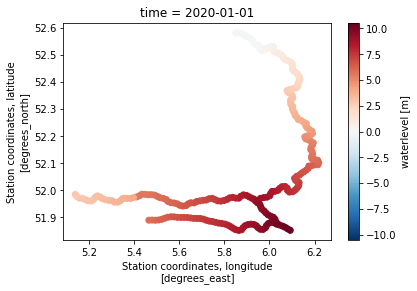

In [4]:
ds.isel({"time": 24}).plot.scatter(x='lon', y='lat', hue='waterlevel')

# Export
Here we convert the station names from the dataset to a geosjson file. We store the results in station-names.json. 

In [5]:
# Export to geojson format 
df = pd.DataFrame({
    "stations": ds.nodenames.to_pandas().str.decode('utf-8').values,
    "lat": ds.lat.values,
    "lon": ds.lon.values
})
df = df.set_index('stations')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
gdf.to_file('station-names.json')


# Compute statistics
Here we take two years of forecasts to compute  the discharge - waterlevel/velocity relation. We take the discharge at Lobith and the waterlevel and velocity at Thiel. We will start by looking at one forecast series. We can select the discharge and take the waterlevel 12 hours later. 

In [6]:
# select discharge
discharge = ds.discharge.isel({"time": 0, "stations": lobith_idx})
# select waterlevel 24 timesteps later
waterlevel = ds.waterlevel.isel({"time": 12, "stations": thiel_idx})
discharge.time.values, waterlevel.time.values


(numpy.datetime64('2019-12-31T00:00:00.000000000'),
 numpy.datetime64('2019-12-31T12:00:00.000000000'))

In [7]:
f"Discharge at Lobith {discharge.values:.0f} m3/s corresponds to waterlevel, 1 day later at {waterlevel.values:.1f} m at Thiel"

'Discharge at Lobith 3256 m3/s corresponds to waterlevel, 1 day later at 6.0 m at Thiel'

Now we will open all the files at once, concatenate them on the analysis time dimension using a nested approach, because time shifts over the forecasts. This should generate a long timeseries

In [8]:
ds_all = xr.open_mfdataset((data_dir / '2020-2021').glob('maps1d_fews_riv_rijn_km_*.nc'), concat_dim="analysis_time", combine='nested')
assert len(set(np.diff(ds_all.time.values)))  == 1, "all time differences should be equal"

In [9]:
ds_all

<xarray.Dataset>
Dimensions:        (time: 17671, analysis_time: 788, stations: 244)
Coordinates:
  * time           (time) datetime64[ns] 2019-12-31 ... 2022-01-05T06:00:00
  * analysis_time  (analysis_time) datetime64[ns] 2021-07-14T07:00:00 ... 202...
    lat            (analysis_time, stations) float64 dask.array<chunksize=(1, 244), meta=np.ndarray>
    lon            (stations) float64 dask.array<chunksize=(244,), meta=np.ndarray>
Dimensions without coordinates: stations
Data variables:
    y              (analysis_time, stations) float64 dask.array<chunksize=(1, 244), meta=np.ndarray>
    x              (analysis_time, stations) float64 dask.array<chunksize=(1, 244), meta=np.ndarray>
    z              (analysis_time, stations) float64 dask.array<chunksize=(1, 244), meta=np.ndarray>
    node_id        (analysis_time, stations) |S64 dask.array<chunksize=(1, 244), meta=np.ndarray>
    nodenames      (analysis_time, stations) |S255 dask.array<chunksize=(1, 244), meta=np.ndarray>
    waterlevel     (analysis_time, time, stations) float32 dask.array<chunksize=(1, 17671, 244), meta=np.ndarray>
    velocity       (analysis_time, time, stations) float32 dask.array<chunksize=(1, 17671, 244), meta=np.ndarray>
    discharge      (analysis_time, time, stations) float32 dask.array<chunksize=(1, 17671, 244), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                  CF-1.6
    title:                        Data
    institution:                  Deltares
    source:                       Export NETCDF-CF_TIMESERIES_MATROOS from De...
    history:                      2021-07-14 16:54:14 GMT: exported from Delf...
    references:                   http://www.delft-fews.com
    ...                           ...
    time_coverage_start:          2021-07-13T00:00:00+0000
    time_coverage_end:            2021-07-19T07:00:00+0000
    geospatial_lon_min:           5.140201330591657
    geospatial_lon_max:           6.218290736375574
    geospatial_lat_min:           51.851251890283976
    geospatial_lat_max:           52.582753563604136

Now we can select waterlevels, discharge and velocities for all timesteps. We could decide to filter by time difference with analysis time. We could compare 12 hours ahead with the analysis time. For now let's use all the data (all time combinations). 

In [10]:
discharge = ds_all.discharge.isel({"stations": lobith_idx})
waterlevel = ds_all.waterlevel.isel({"stations": thiel_idx})
velocity = ds_all.velocity.isel({"stations": thiel_idx})


Let's visualize the data by showing the histograms.

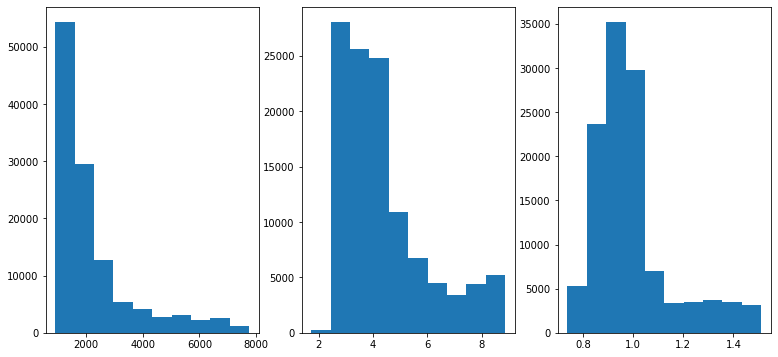

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 6))
axes[0].hist(discharge.values.ravel())
axes[1].hist(waterlevel.values.ravel())
axes[2].hist(velocity.values.ravel());


Show the Q-h and Q-v relationship. Now we just do it for 1 location, but we need it for all locations. We also need to incorporate the time lag and to fit a non-parametric monotonic increasing function. But that's for a later moment. For now let's just inspect the functions.

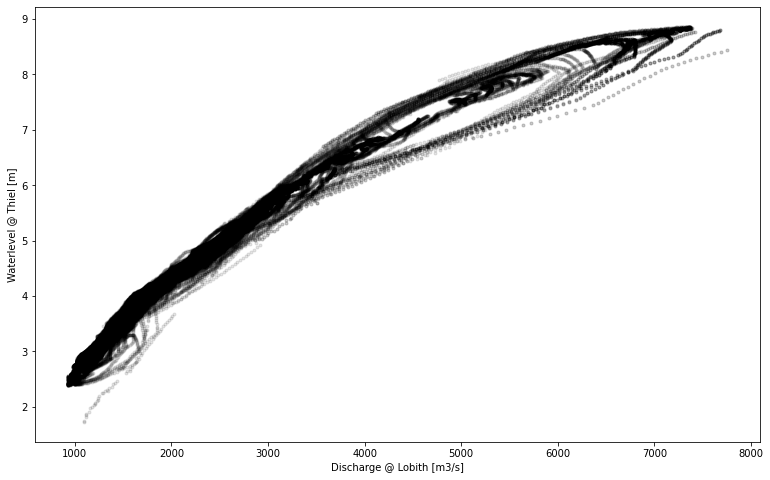

In [12]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(discharge.values.ravel(), waterlevel.values.ravel(), 'k.', alpha=0.1)
ax.set_xlabel('Discharge @ Lobith [m3/s]')
ax.set_ylabel('Waterlevel @ Thiel [m]');

Text(0, 0.5, 'Velocity @ Thiel [m]')

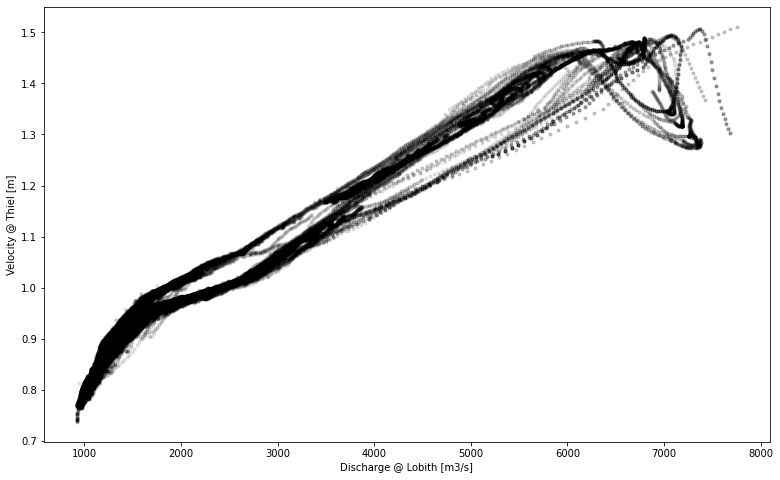

In [13]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(discharge.values.ravel(), velocity.values.ravel(), 'k.', alpha=0.1)
ax.set_xlabel('Discharge @ Lobith [m3/s]')
ax.set_ylabel('Velocity @ Thiel [m]')